# Lab 1b

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Helper functions
def mse(x, y, w):
       e = (w @ x) - y   
       return 0.5 * np.mean(e**2)

## Fix data

In [25]:
##### Generate samples #####
def data_generator(
        n: int=100,
        mA:list[float, float]=[1.0, 0.3],
        mB:list[float, float]=[0.0, -0.1],
        sigmaA: float=0.2,
        sigmaB: int=0.3
        ):
    
    # First row of class A is handled differently
    firstrowA = np.concatenate([
        np.random.randn(n // 2) * sigmaA - mA[0],
        np.random.randn(n // 2) * sigmaA + mA[0]
    ])

    # Create the classes
    classA = np.vstack(
        tup=(firstrowA, np.random.randn(n) * sigmaA + mA[1])
    )
    classB = np.random.randn(n, 2) * sigmaB + mB
    classB = classB.transpose()

    # Add the bias term
    classA = np.vstack(tup=(classA, np.ones((1, n))))
    classB = np.vstack(tup=(classB, np.ones((1, n))))

    # Combine data into one ndarray
    input_data = np.concatenate((classA, classB), axis=1)

    # Create shuffled indices. Will be used to shuffle the samples
    shuffled_indices = np.random.permutation(input_data.shape[1])

    # Shuffle input data
    input_data_shuffled = input_data[:, shuffled_indices]

    # Target data (delta rule)
    targets = np.concatenate((np.ones(classA.shape[1]), -np.ones(classB.shape[1])))
    targets_shuffled = targets[shuffled_indices] # Shuffle targets

    return classA, classB, input_data_shuffled, targets_shuffled

##### Weight generator #####
def weight_generator(X_dim_wo_bias: int, hidden_nodes: list[int], output_nodes: int=1):
    weights = []

    # Create a list to define number of nodes in each layer, starting from input layer
    # For our 2-layer perceptron, we will have 1 input layer, 1 hidden layer and 1 output layer
    layer_nodes = [X_dim_wo_bias] + hidden_nodes + [output_nodes]

    # We start from l = 1, because we will create the weights using the dimensions of previous
    # layer (columns) and number of nodes in current layer (rows). The + 1 one the columns is to add the bias term
    for i in range(1, len(layer_nodes)):
        W = np.random.randn(layer_nodes[i], layer_nodes[i - 1] + 1)

        weights.append(W)
    
    return weights

### Sanity check data generator

In [21]:
classA, classB, X, target = data_generator(mA=[2.0, 0.3])
print(classA.shape)
print(classB.shape)
print(type(X))
print(target.shape)

(3, 100)
(3, 100)
<class 'numpy.ndarray'>
(200,)


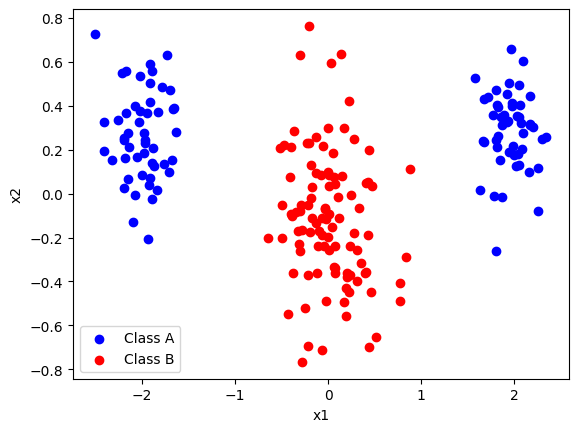

In [9]:
plt.scatter(classA[0, :], classA[1, :], color="blue", label="Class A")
plt.scatter(classB[0, :], classB[1, :], color="red", label="Class B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [37]:
weights = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[5], output_nodes=1)
for w in weights:
    print(w.shape)


(5, 3)
(1, 6)


## Generalized delta rule

In [87]:
###### Activation function (as in the lab instructions) #####
def activation_function(h_in):
    phi = (2 / (1 + np.exp(-h_in))) - 1
    d_phi = ((1 + phi) * (1 - phi)) / 2

    return phi, d_phi

##### Forward pass #####
def forward_pass(X, weights):
    print("===== Forward pass =====")
    # List to keep track of what should be sent into the following hidden layer
    activations_list = [X] # First element is the input, and the last element correspond to the output (i.e. t)
    
    phi_and_d_phi = [] # Store results of the activation function (both the values and the derivate) 

    for i, W in enumerate(weights):
        print(f"Layer {i}: W shape {W.shape}, input shape {activations_list[-1].shape}")
        h_in = W @ activations_list[-1] # Get the output from the latest calculated layer, and use it as input for next layer

        # Calcualte output of hidden layer and store both outpout and derivate (they will be used in back propogation)
        h_out, d_phi = activation_function(h_in)
        print(f"Layer {i}: h_out shape {h_out.shape}, d_phi shape {d_phi.shape}")


        phi_and_d_phi.append((h_out, d_phi))

        # Calculate bias term and add it to phi (output of the layer), for all layers, except the last one
        if i < (len(weights) - 1):
            bias_term = h_out.shape[1]
            h_out = np.vstack(tup=(h_out, np.ones((1, bias_term))))

        activations_list.append(h_out)

    return activations_list, phi_and_d_phi

##### Backward pass #####
def backward_pass(targets, phi_and_d_phi, weights):
    print("===== Backward pass =====")
    # Initialize list with the deltas. Makes it easier to call the correct delta when calculating hidden layers delta
    deltas = [None] * len(phi_and_d_phi)

    # Go through each element of phi_and_d_phi in reversed order. 
    # In the first iteration, i = len(phi_and_d_phi) - 1 (last element of phi_and_d_phi)
    for i, (h_out, d_phi) in reversed(list(enumerate(phi_and_d_phi))):
        # We handle output layer (last element of phi_and_d_phi) differently from hidden layers
        if i == len(phi_and_d_phi) - 1:
            d = (targets - h_out) * d_phi
            print(f"Layer {i} (output): delta shape {d.shape}")
        else:
            v = weights[i + 1][:, :-1] # Drop the weighs for the bias, as the error is calculated based the weighs connecting inputs with nodes in hidden layer, or weighs connecting hiodden layer to outer layer
            print(f"Layer {i} (hidden): v shape {v.shape}, v_transpose shape {np.transpose(v).shape}, previously calculated delta shape {deltas[i + 1].shape}, d_phi shape {d_phi.shape}")
            d = (np.transpose(v) @ deltas[i + 1]) * d_phi # Here we matrix multiply with the latest calculated delta
            print(f"Layer {i} (hidden): delta shape {d.shape}")

        deltas[i] = d # Update the None value to the actual delta values, so the last element in deltas = delta for the output layer nodes

    return deltas

##### Weight update #####
def weight_update(alpha, eta, activations, deltas):
    print("===== Weight update =====")

    return 1

## Testing

In [88]:
classA, classB, X, targets = data_generator(mA=[2.0, 0.3])
# Create weights for 2 perceptron layer (1 hidden layer and 1 output layer)
weights = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[5], output_nodes=1)
v = weights[1][:, :-1]

layer_inputs, phi_and_d_phi = forward_pass(X=X, weights=weights)

deltas = backward_pass(targets=targets, phi_and_d_phi=phi_and_d_phi, weights=weights)

# print(weights[1])
# print(v)
# print(np.transpose(v))
# print(phi_and_d_phi[1][1])



===== Forward pass =====
Layer 0: W shape (5, 3), input shape (3, 200)
Layer 0: h_out shape (5, 200), d_phi shape (5, 200)
Layer 1: W shape (1, 6), input shape (6, 200)
Layer 1: h_out shape (1, 200), d_phi shape (1, 200)
===== Backward pass =====
Layer 1 (output): delta shape (1, 200)
Layer 0 (hidden): v shape (1, 5), v_transpose shape (5, 1), previously calculated delta shape (1, 200), d_phi shape (5, 200)
Layer 0 (hidden): delta shape (5, 200)


In [64]:
a = np.ones(shape=(2, 2))
b = np.random.randn(2, 2)
print(a)
print(b)
print(a*b)

[[1. 1.]
 [1. 1.]]
[[-0.58125839  0.02409173]
 [ 3.03514098 -0.87428132]]
[[-0.58125839  0.02409173]
 [ 3.03514098 -0.87428132]]
